In [1]:
import numpy as np
import gym
import copy
import renom as rm
from renom.optimizer import Adam
from renom_rl.discrete.a2c import A2C
from renom_rl.environ.env import BaseEnv
from tqdm import tqdm
from renom_rl.utility import Animation
import matplotlib.pyplot as plt
from PIL import Image
from renom.cuda import set_cuda_active
from skimage.color import rgb2gray
from skimage.transform import resize

In [2]:
env=gym.make("BreakoutNoFrameskip-v4")
set_cuda_active(True)

class ActorCritic(rm.Model):
    def __init__(self):
        self.c1=rm.Conv2d(32, filter=8, stride=4)
        self.c2=rm.Conv2d(32, filter=4, stride=2)
        self.l1=rm.Dense(256)
        self.l2=rm.Dense(32)
        self.l3=rm.Dense(4)
        self.l4=rm.Dense(1)
        
    def forward(self,x):
        c1 = self.c1(x)
        c2 = self.c2(c1)
        f1 = rm.flatten(c2)
        h1 = self.l1(f1)
        h2 = self.l2(h1)
        r3 = rm.relu(h2)
        act = rm.softmax(self.l3(r3))
        val=self.l4(r3)
        return act,val
    
model=ActorCritic()


In [3]:
class Breakout(BaseEnv):
    
    def __init__(self):
        self.env = gym.make('Breakout-v0')
        self.action_shape = (self.env.action_space.n,)
        self.action_interval = 4
        self.state_shape = (self.action_interval, 84, 84)
        self.test=False
        
        self.animation = Animation(ratio=36.0)
        self.test_mode = False
        
    def reset(self):
        state = self.env.reset()
#         n_step = np.random.randint(30)
        for _ in range(30):
            state, _, _ = self.step(self.env.action_space.sample())
        return state
    
    def sample(self):
        return self.env.action_space.sample()
    
   
    def _preprocess(self, state_list):
        processed_state_list = []
        for s in state_list:
            processed_state = resize(rgb2gray(s), (84, 84))
            processed_state_list.append(processed_state)
        
        if len(processed_state_list) is not self.action_interval:
            for _ in range(self.action_interval - len(processed_state_list)):
                processed_state_list.append(processed_state_list[-1])
        
        return np.array(processed_state_list)
        
    def step(self, action):
        state_list = []
        reward_list = []
        
        for _ in range(self.action_interval):
            state, reward, terminal, _ = self.env.step(int(action))
            state_list.append(state)
            reward_list.append(reward)
            
            if terminal:
                break
                
        processed_state = self._preprocess(state_list)
        
        return processed_state, sum(reward_list), terminal
    
    def test_start(self):
        if self.test:
            self.animation.reset()
            self.env.reset()
    
    def test_epoch_step(self):
        if self.test:
            self.animation.store(self.env.render(mode="rgb_array"))
    
    def test_close(self):
        #self.env.close() 
        if self.test:
            self.env.viewer = None
    
env = Breakout()
q_network = rm.Sequential([rm.Conv2d(32, filter=8, stride=4),
                           rm.Relu(),
                           rm.Conv2d(64, filter=4, stride=2),
                           rm.Relu(),
                           rm.Conv2d(64, filter=3, stride=1),
                           rm.Relu(), 
                           rm.Flatten(), 
                           rm.Dense(512),
                           rm.Relu(),
                           rm.Dense(env.action_shape[0])])

In [4]:
Env=Breakout()
opt=Adam(lr=0.01)
from renom_rl.utility import ProbNodeChooser
from renom_rl.utility import GradientClipping

a2c=A2C(Env,
        model,
        loss_func=opt,
        test_node_selector=ProbNodeChooser(),
        gradient_clipping=GradientClipping(),
        )

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
a2c.fit(
    epoch=1,
    epoch_step=1000)

epoch 001 avg_loss:0.0240 total reward in epoch: [train:204.000 test: 0.0] avg train reward in episode:1.127: 100%|██████████| 1000/1000 [01:26<00:00, 12.16it/s]


In [6]:
Env.test=True
a2c.test()
Env.test=False


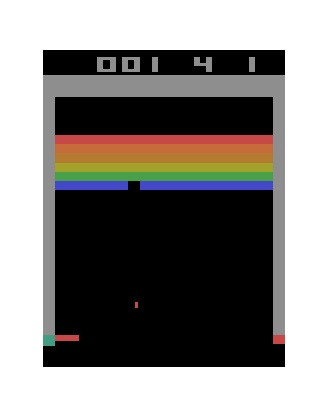
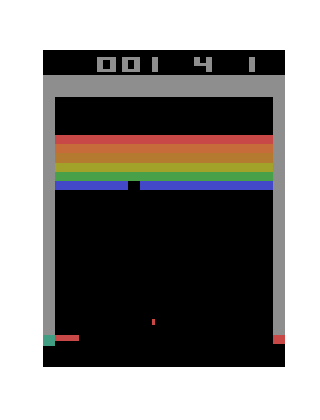
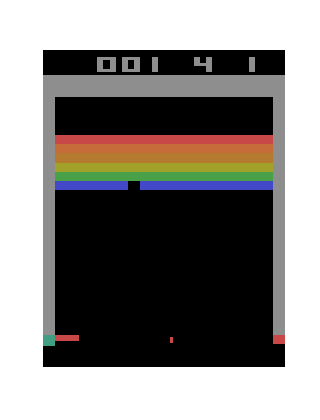
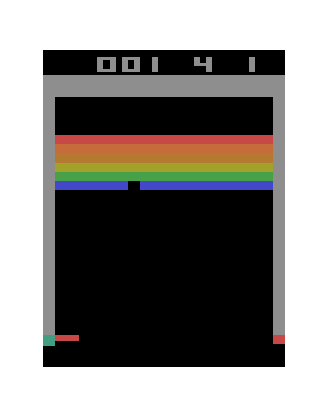
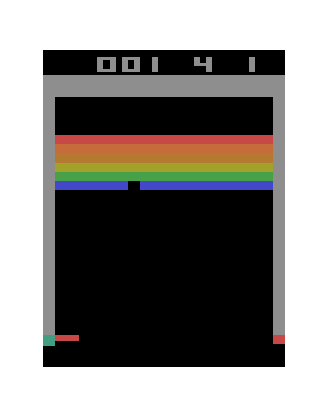
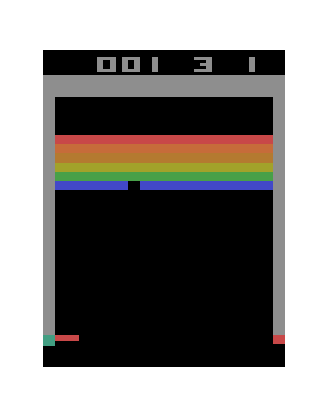
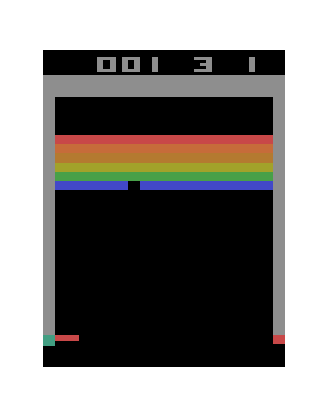
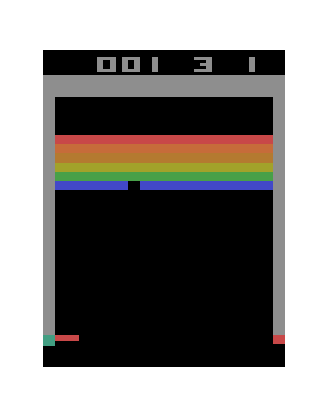
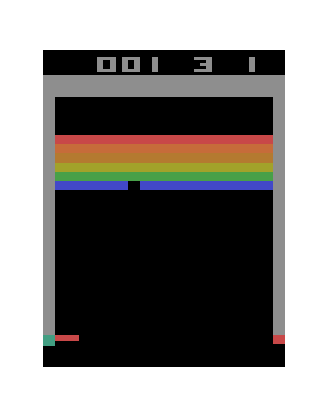
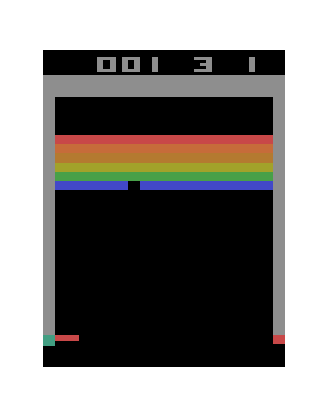
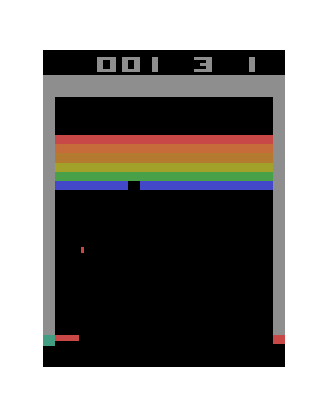
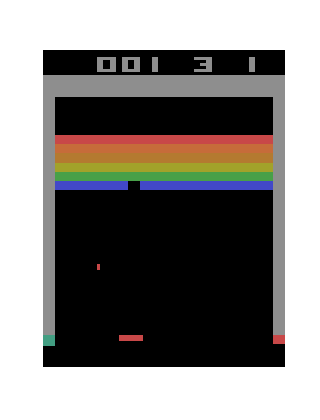
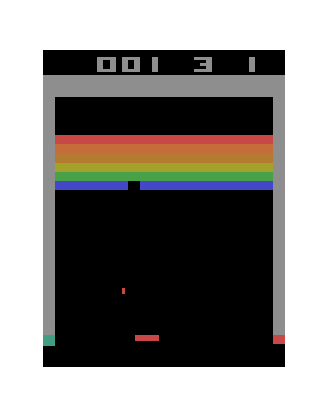
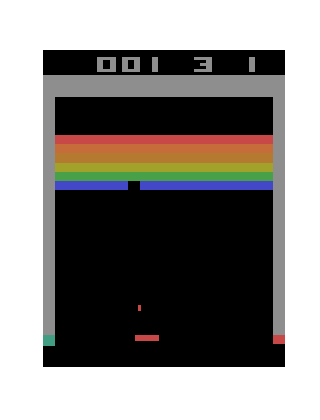
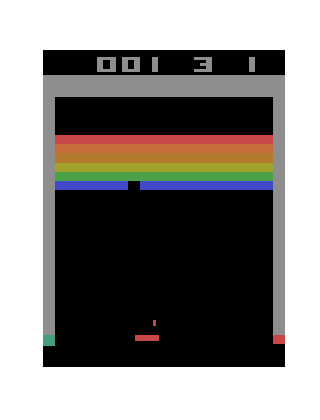
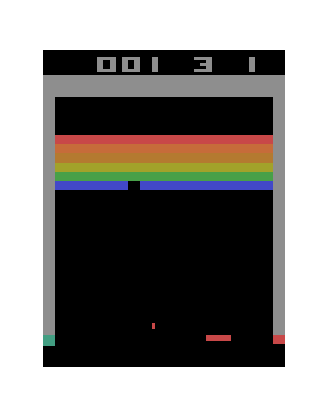
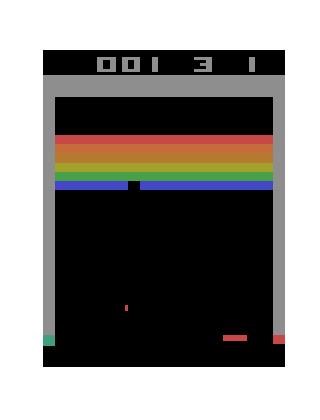
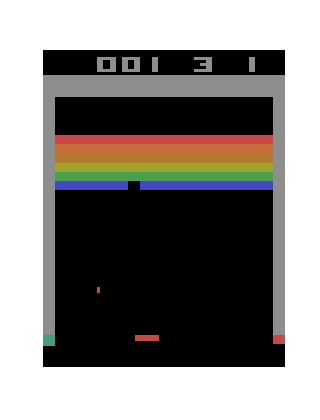
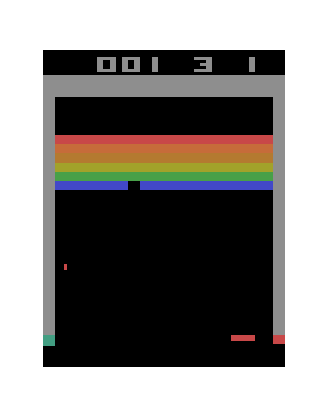
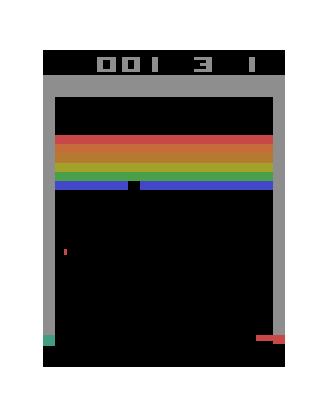
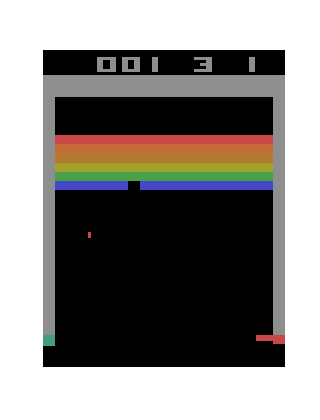
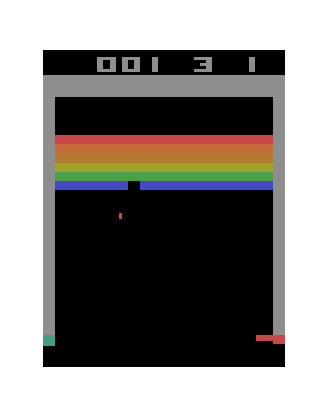
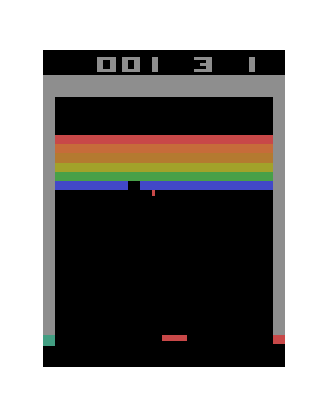
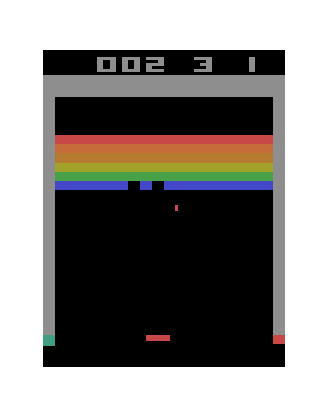
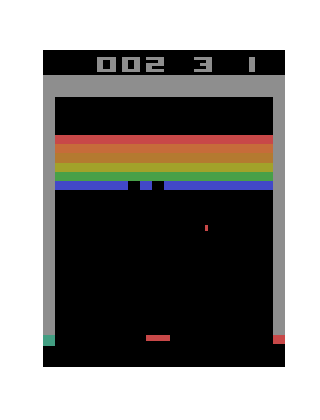
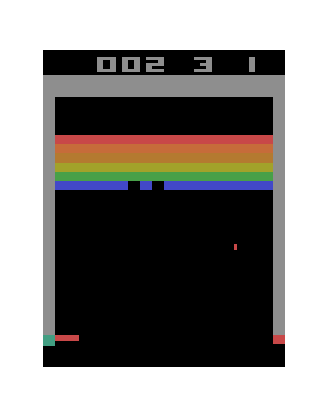
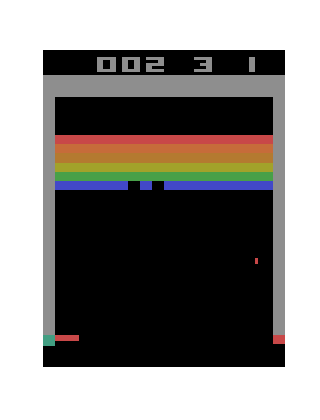
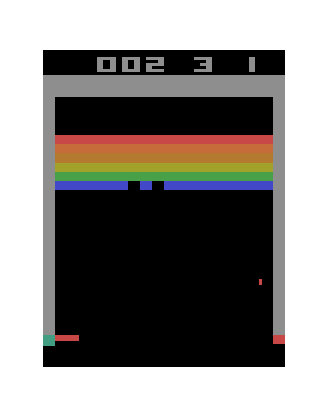
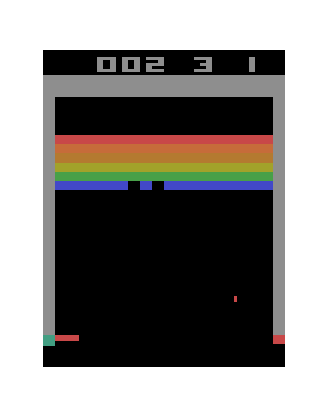
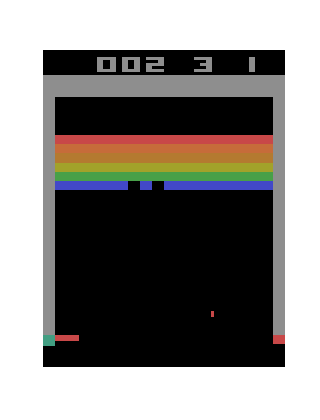
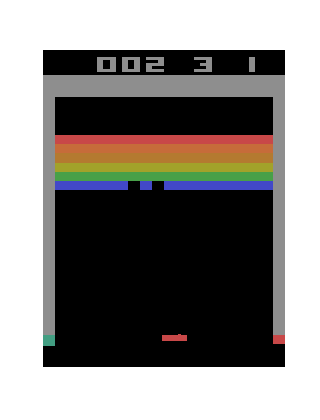
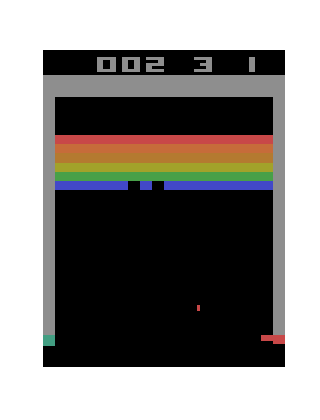
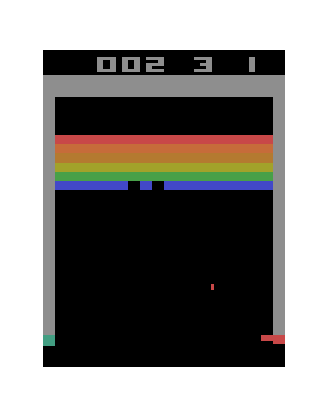
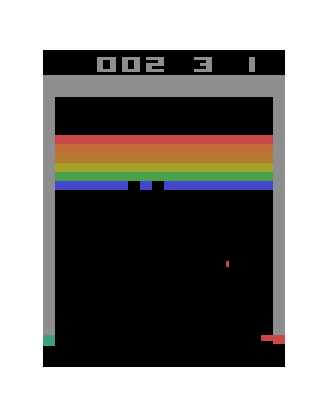
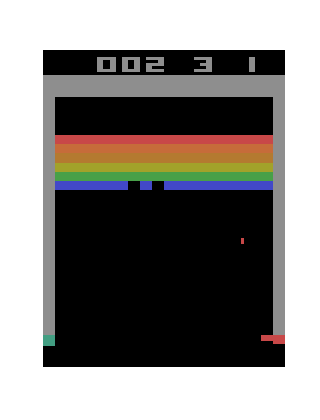
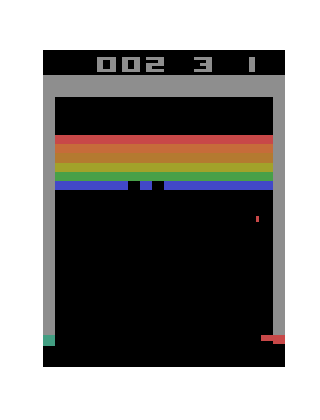
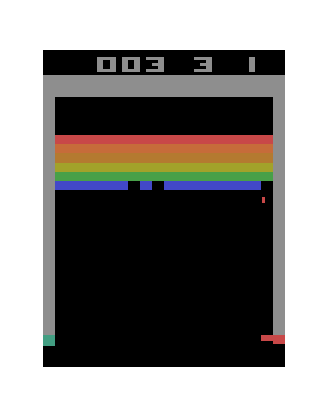
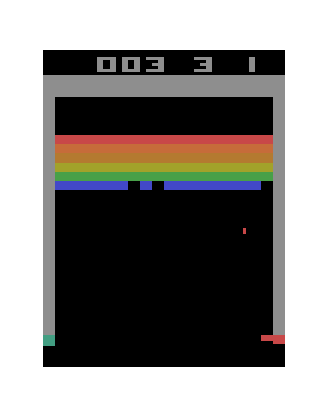
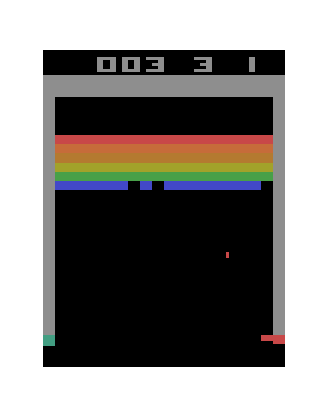
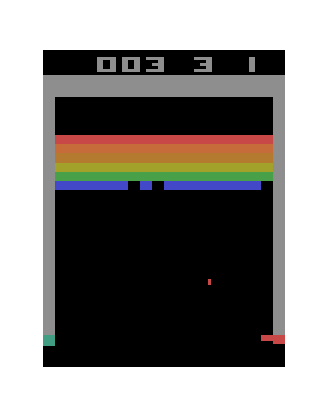
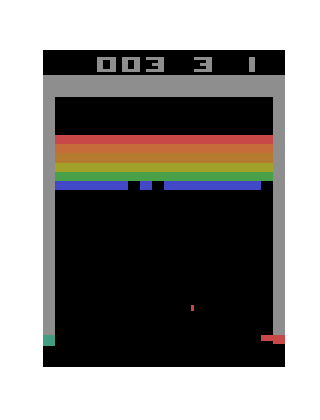
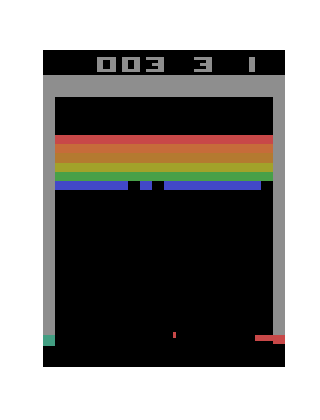
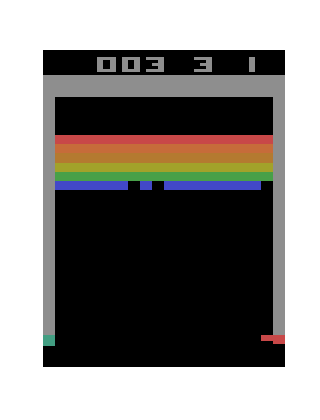
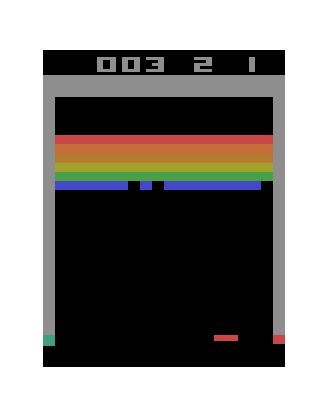
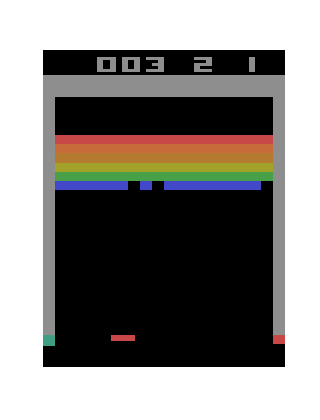
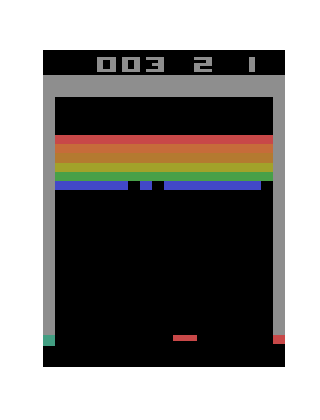
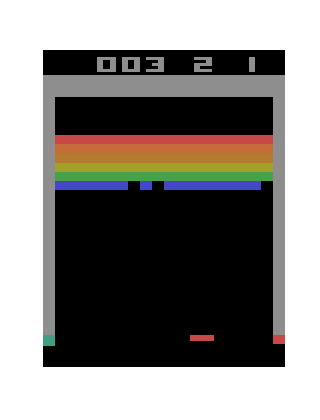
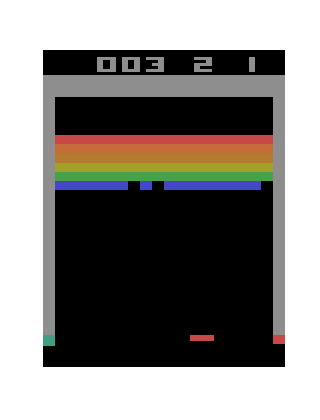
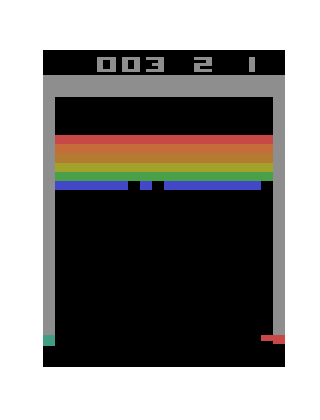
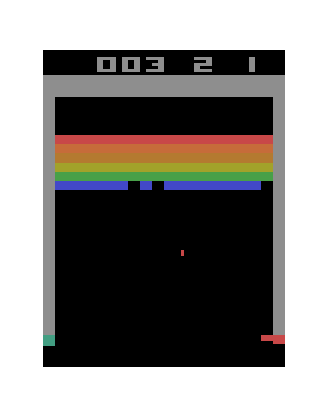
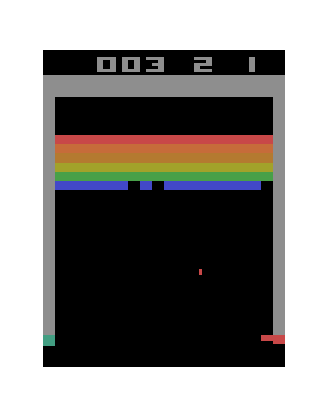
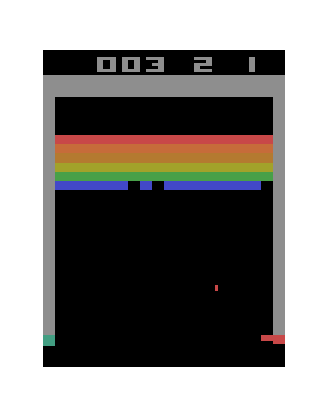
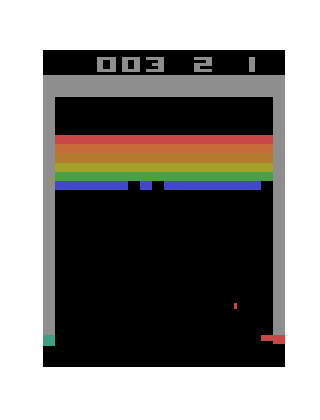
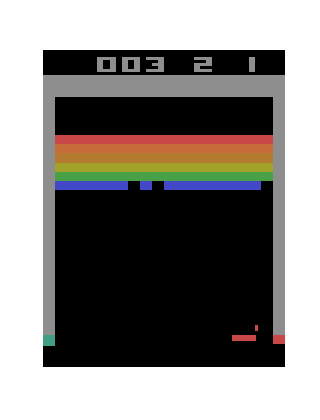
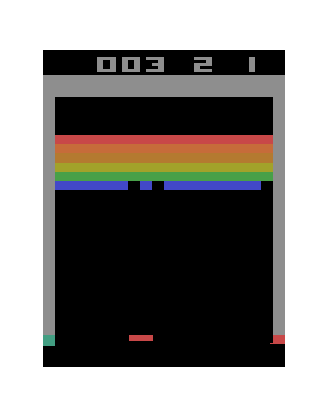
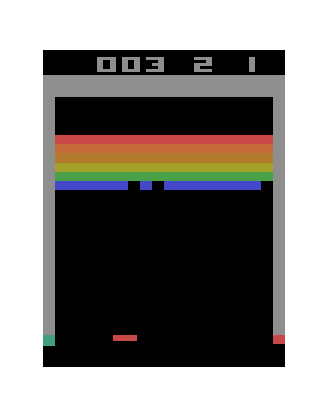
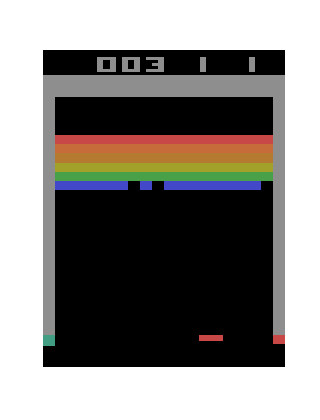
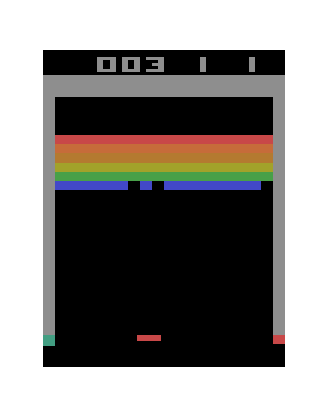
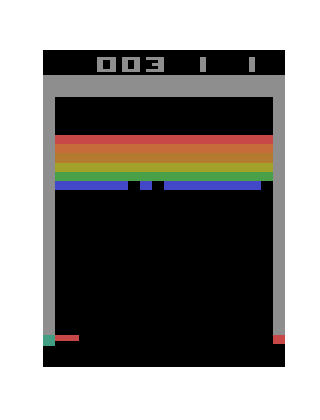
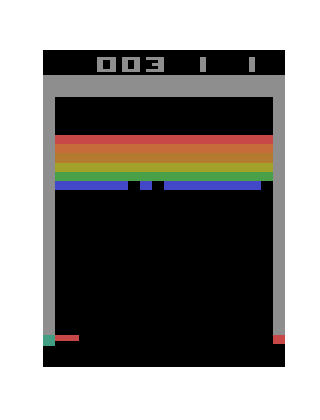
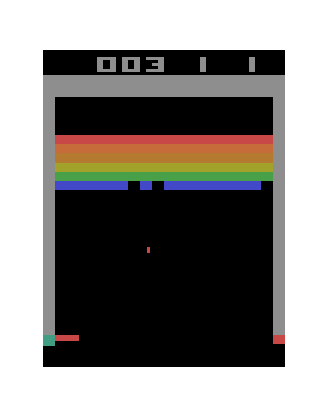
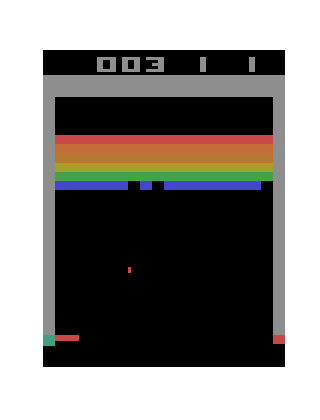
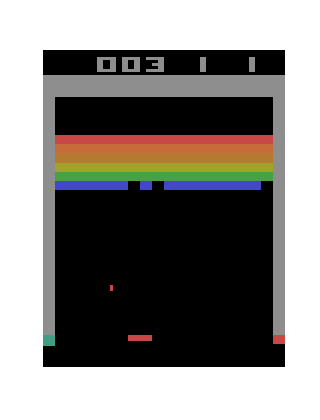
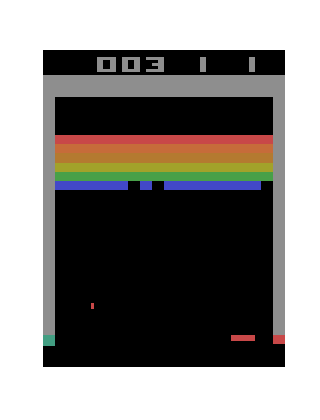
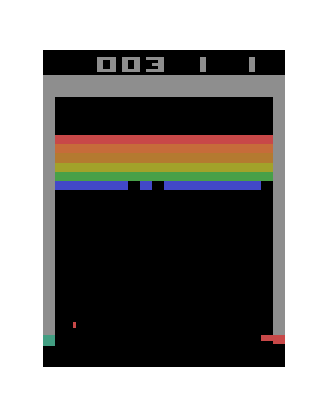
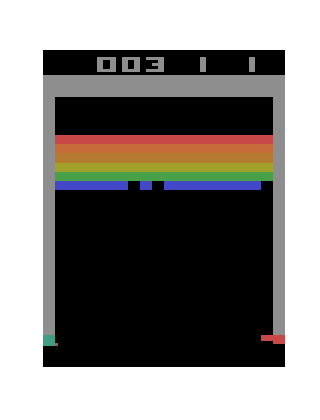
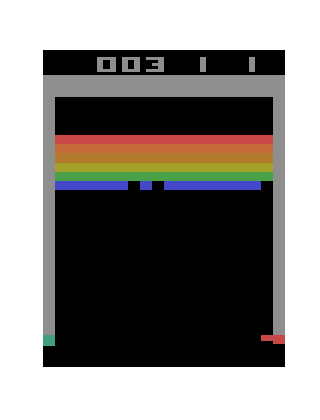
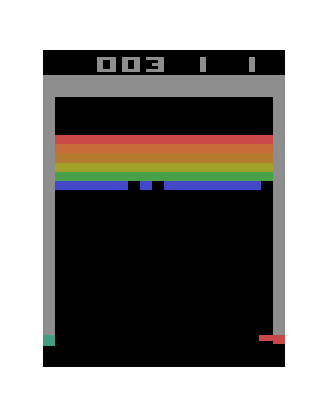

In [7]:
Env.animation.run()
Env.animation.reset()